### NINO 3.4

In [78]:
%matplotlib inline
from matplotlib import pyplot as plt

In [79]:
import sys
import pathlib

In [80]:
import pandas as pd
import numpy as np
from dateutil import parser as dparser
from datetime import datetime, timedelta
import subprocess

In [81]:
clim_start = 1981
clim_end = 2010

### Get the NINO 3.4 INDEX, based on the ERSST V5 SST dataset 

In [82]:
NINO_url = 'http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.81-10.ascii'

In [83]:
nino = pd.read_csv(NINO_url, sep='\s+', engine='python')

In [84]:
nino.columns

Index(['YR', 'MON', 'NINO1+2', 'ANOM', 'NINO3', 'ANOM.1', 'NINO4', 'ANOM.2',
       'NINO3.4', 'ANOM.3'],
      dtype='object')

In [85]:
nino.tail()

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
846,2020,7,20.68,-1.24,25.21,-0.48,28.89,0.15,26.98,-0.20
847,2020,8,19.96,-1.05,24.50,-0.60,28.47,-0.17,26.26,-0.58
848,2020,9,19.51,-1.23,23.91,-1.02,28.21,-0.45,25.88,-0.85
849,2020,10,20.25,-0.80,23.85,-1.11,27.96,-0.68,25.46,-1.21
850,2020,11,20.86,-0.83,23.88,-1.15,27.85,-0.71,25.31,-1.31


In [86]:
nino = nino[['YR','MON','NINO3.4']]

In [87]:
nino.tail()

,YR,MON,NINO3.4
846,2020,7,26.98
847,2020,8,26.26
848,2020,9,25.88
849,2020,10,25.46
850,2020,11,25.31


In [88]:
nino.loc[:,'DAY'] = 1

In [89]:
nino_clim = nino.copy()

In [90]:
nino_clim.index = nino_clim.YR

In [91]:
nino_clim = nino_clim.loc[1981:2010,:]

In [92]:
nino_clim = nino_clim.groupby(nino_clim.MON).mean()

### get a proper datetime index from the `[['YR', 'MON', 'DAY']]` columns

In [93]:
nino.index = nino[['YR', 'MON', 'DAY']].apply(lambda d : datetime(*d), axis = 1)

In [94]:
nino.tail()

,YR,MON,NINO3.4,DAY
2020-07-01,2020,7,26.98,1
2020-08-01,2020,8,26.26,1
2020-09-01,2020,9,25.88,1
2020-10-01,2020,10,25.46,1
2020-11-01,2020,11,25.31,1


### anomalies WRT to the climatology defined above (1981 - 2010)

In [95]:
def demean(x): 
    return x - x.loc[str(clim_start):str(clim_end)].mean()

In [96]:
nino['anoms'] = nino.groupby(nino.MON)[['NINO3.4']].transform(demean)

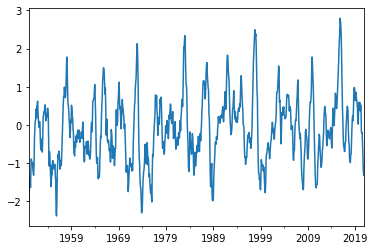

In [97]:
nino.anoms.plot()

In [98]:
ninos = nino[['anoms']]
ninos.columns = ['NINO34']

In [99]:
nino.tail()

,YR,MON,NINO3.4,DAY,anoms
2020-07-01,2020,7,26.98,1,-0.198667
2020-08-01,2020,8,26.26,1,-0.574000
2020-09-01,2020,9,25.88,1,-0.847333
2020-10-01,2020,10,25.46,1,-1.213000
2020-11-01,2020,11,25.31,1,-1.317667


### selects only the anomalies 

In [100]:
nino  = nino.loc[:,['anoms']]

In [101]:
nino.columns = ['NINO34_monthly']

### offset to end of month 

In [102]:
nino.index = nino.index + pd.offsets.MonthEnd(0) 

In [103]:
opath = pathlib.Path("/media/nicolasf/END19101/data/climate_indices/observed/NINO34/")

In [104]:
if not opath.exists(): 
    opath.mkdir(parents=True)

In [105]:
nino.index.name = 'date'

In [106]:
nino.index = nino.index + pd.offsets.MonthEnd(0)

### calculates the seasonal anomalies 

In [107]:
ninos = nino.rolling(window=3, min_periods=3).mean() 

In [108]:
ninos.columns = [x + '_seasonal' for x in ninos.columns]

In [109]:
nino = pd.concat([nino, ninos], axis=1)

In [110]:
nino.head()

,NINO34_monthly,NINO34_monthly_seasonal
date,,
1950-01-31,-2.002333,NaN
1950-02-28,-1.681667,NaN
1950-03-31,-1.364667,-1.682889
1950-04-30,-1.429667,-1.492000
1950-05-31,-1.632000,-1.475444


In [111]:
nino.to_csv(opath.joinpath("NINO34.csv"))